In [2]:
import numpy as np
import awkward as ak
import uproot
import src.functions as fn
from pylab import cm
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
import os
import random
seed1=12
seed2=54

In [3]:
#%matplotlib inline

import mplhep as hep

# Make plots look more HEP-like
plt.style.use(hep.style.ROOT)

In [51]:
#filenameBase="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/"

#filename="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta3_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225846/0000/hgcalNtuple_*.root:ana/tracksters"
#filenameFull100GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E100Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225928/0000/ntuples.root"
#filenameFull50GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E50Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225808/0000/ntuples.root"
filenameFull25GeV="/eos/user/c/chpapage/TICL_samples/CloseByDoubleGamma_E25Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4_ntuples/220701_225704/0000/ntuples.root"
folder="CloseByDoubleGamma_E25Eta1p62Delta5_CMSSW_12_4_0_upgrade2026_D86_clue3Dv4"
#file = uproot.open(filename)
#fileFull=uproot.concatenate(filename)
file=uproot.open(filenameFull25GeV)
datasetName="Double gamma 25 GeV Delta 5"

In [52]:
tracksters=file["ana/tracksters"]
clusters=file["ana/clusters"]
vertices_indexes = tracksters['vertices_indexes'].array()
vertices_x = tracksters['vertices_x'].array()
vertices_y = tracksters['vertices_y'].array()
vertices_z = tracksters['vertices_z'].array()
vertices_E = tracksters['vertices_energy'].array()
vertices_layer = tracksters['vertices_layer'].array()


In [53]:
tracksterChoice=[0]*500+[1]*500
random.shuffle(tracksterChoice)
tracksterChoice=np.asarray(tracksterChoice).reshape((500,2))

In [54]:
print(sum(tracksterChoice))
print(len(tracksterChoice))

[243 257]
500


In [55]:
comShowerShapes=[]
incShowerShapes=[]

longestComPaths=[]
longestInComPaths=[]

longestComPathsFirstNode=[]
longestInComPathsFirstNode=[]

comCenParams=[]
incCenParams=[]

N = len(vertices_indexes)
#N_tr=10000

for evt in range(N):
    for tr in range(min(len(vertices_indexes[evt]),2)):
        v_layers=vertices_layer[evt][tr]
        v_ind=vertices_indexes[evt][tr]
        v_x=vertices_x[evt][tr]
        v_y=vertices_y[evt][tr]
        v_z=vertices_z[evt][tr]
        v_E=vertices_E[evt][tr] 
        
        edges_1 = fn.edgeBuilderNew(
            v_ind,
            v_x, 
            v_y, 
            v_z, 
            v_E
        )
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
        
        if(tracksterChoice[evt,tr]):
            c_pr_dir=fn.centralityPageRank(v_ind,edges_1,0.85,True)
            c_pr_undir=fn.centralityPageRank(v_ind,edges_1,0.85,False)
            longestComPaths.append([fn.longestPathSource(v_ind,edges_1,c_pr_dir,True),fn.longestPathSource(v_ind,edges_1,c_pr_undir)])
        
            longestComPathsFirstNode.append([fn.longestPathInitialNode(v_ind,edges_1,True),fn.longestPathInitialNode(v_ind,edges_1)])
       
            centrality=c_pr_dir
            comCenParams.append([np.mean(centrality),np.std(centrality)
                             ,scipy.stats.skew(centrality),scipy.stats.kurtosis(centrality)])
            
            comShowerShapes.append([
                fn.ld(v_z,v_E),
                fn.sd(v_z,v_E),
                fn.delta_R(v_x,v_y,v_z,v_E),
                fn.delta_RT(v_x,v_y,v_E),
                fn.delta_RT(v_x,v_y,v_E,True),
                ak.sum(v_E),
                fn.maxE_z(v_z,v_E),
                fn.maxAbsZ(v_z),
                fn.delta_RT_std(v_x,v_y,v_E)                
            ])
            
        else:
            incSlice=fn.incompleteTracksters2(v_layers,seed1,seed2)
            v_ind_inc=v_ind[incSlice]
            v_x_inc=v_x[incSlice]
            v_y_inc=v_y[incSlice]
            v_z_inc=v_z[incSlice]
            v_E_inc=v_E[incSlice]
            edges_1 = fn.edgeBuilderNew(
                v_ind_inc,
                v_x_inc, 
                v_y_inc, 
                v_z_inc,
                v_E_inc
            )
            edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
            if(len(v_ind_inc)<2):
                continue
            
            c_pr_dir=fn.centralityPageRank(v_ind_inc,edges_1,0.85,True)
            c_pr_undir=fn.centralityPageRank(v_ind_inc,edges_1,0.85,False)
            longestInComPaths.append([fn.longestPathSource(v_ind_inc,edges_1,c_pr_dir,True),fn.longestPathSource(v_ind_inc,edges_1,c_pr_undir)])
            
            longestInComPathsFirstNode.append([fn.longestPathInitialNode(v_ind_inc,edges_1,True),fn.longestPathInitialNode(v_ind_inc,edges_1)])
 
            centrality=c_pr_dir
            incCenParams.append([np.mean(centrality),np.std(centrality)
                             ,scipy.stats.skew(centrality),scipy.stats.kurtosis(centrality)])
            
            incShowerShapes.append([
                fn.ld(v_z_inc,v_E_inc),
                fn.sd(v_z_inc,v_E_inc),
                fn.delta_R(v_x_inc,v_y_inc,v_z_inc,v_E_inc),
                fn.delta_RT(v_x_inc,v_y_inc,v_E_inc),
                fn.delta_RT(v_x_inc,v_y_inc,v_E_inc,True),
                ak.sum(v_E_inc),
                fn.maxE_z(v_z_inc,v_E_inc),
                fn.maxAbsZ(v_z_inc),
                fn.delta_RT_std(v_x_inc,v_y_inc,v_E_inc)                
            ])



In [56]:
comShowerShapes=np.asarray(comShowerShapes)
incShowerShapes=np.asarray(incShowerShapes)
longestComPaths=np.asarray(longestComPaths)
longestInComPaths=np.asarray(longestInComPaths)
longestComPathsFirstNode=np.asarray(longestComPathsFirstNode)
longestInComPathsFirstNode=np.asarray(longestInComPathsFirstNode)
comCenParams=np.asarray(comCenParams)
incCenParams=np.asarray(incCenParams)

In [57]:
def plotShowerShapes(completeShowerShapes,incompleteShowerShapes,xlabels,saveFileNames,bins=50):
    %matplotlib inline
    for i in range(len(completeShowerShapes[0])):
        plt.figure(figsize=(8,6))
        plt.hist(completeShowerShapes[:,i], histtype="step",bins=bins, color='b',label='Complete')
        plt.hist(incompleteShowerShapes[:,i], histtype="step",bins=bins, color='r',label='Incomplete')
        plt.legend()
        plt.ylabel("N",fontsize=20)
        plt.xlabel(xlabels[i],fontsize=20)
        plt.title(datasetName,fontsize=20)
        #plt.xlim(min(completeShowerShapes[:,i]-5),max(completeShowerShapes[:,i]+5))
        plt.savefig("figures/"+folder+"/"+saveFileNames[i]+".png")
        plt.show()

['incVsCom_ld', 'incVsCom_sd', 'incVsCom_delta_R', 'incVsCom_delta_RT', 'incVsCom_delta_RT_Eweighted', 'incVsCom_Total_energy', 'incVsCom_maxE_Z_position', 'incVsCom_maxium_Z_position', 'incVsCom_delta_R_std']


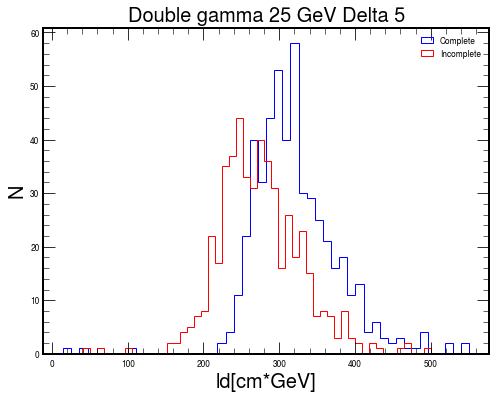

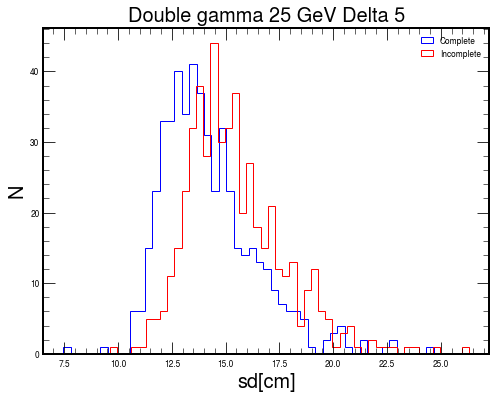

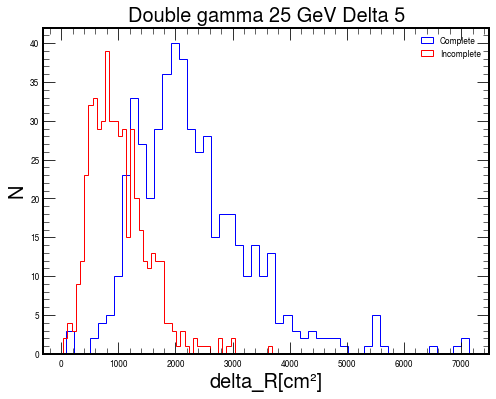

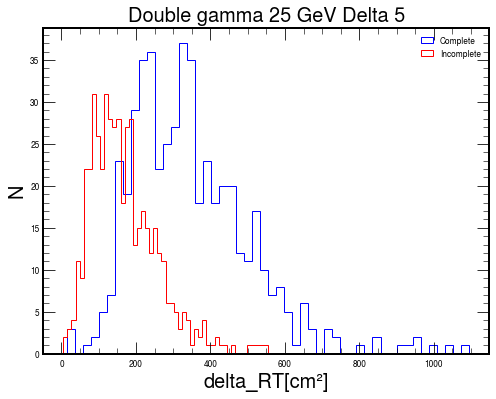

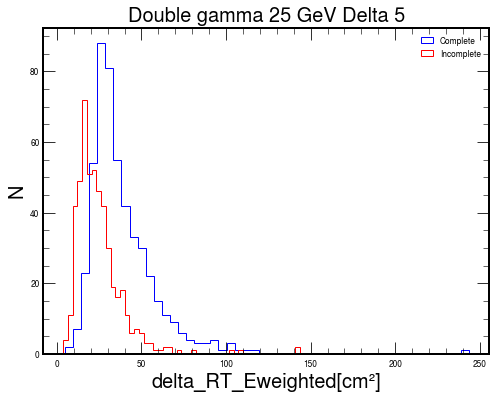

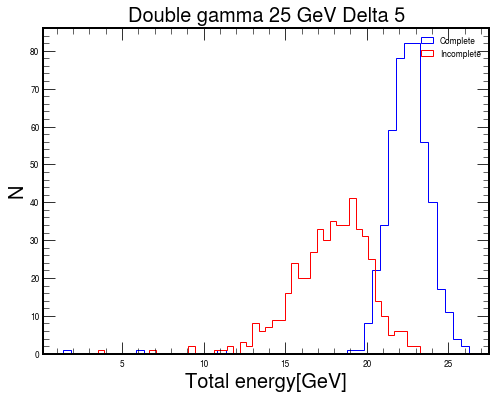

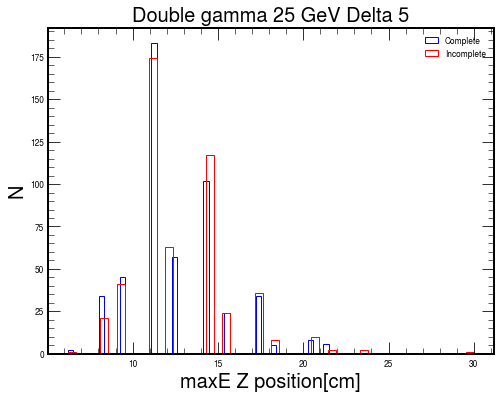

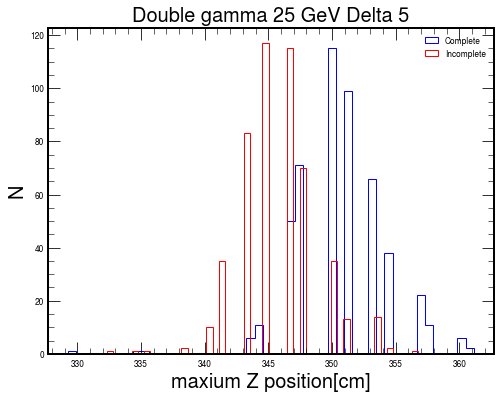

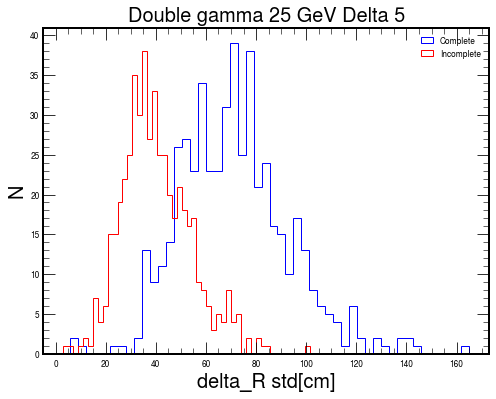

In [58]:
xlabels=["ld[cm*GeV]","sd[cm]","delta_R[cm²]","delta_RT[cm²]","delta_RT_Eweighted[cm²]","Total energy[GeV]","maxE Z position[cm]","maxium Z position[cm]","delta_R std[cm]"]
xlabels2=["ld","sd","delta_R","delta_RT","delta_RT_Eweighted","Total energy","maxE Z position","maxium Z position","delta_R std"]

newList=[("incVsCom_"+i.replace(" ","_")) for i in xlabels2]
print(newList)
if not os.path.isdir("figures/"+folder):
    os.makedirs("figures/"+folder)
plotShowerShapes(comShowerShapes,incShowerShapes,xlabels,newList)

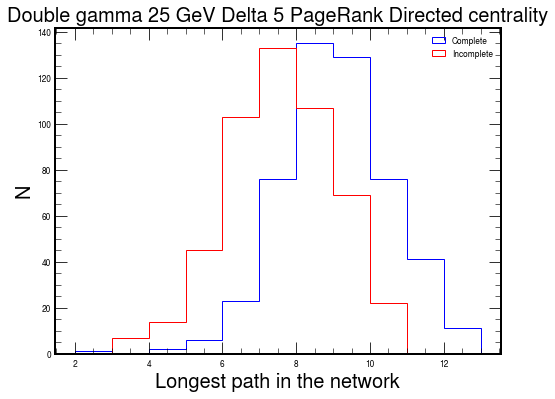

In [59]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPaths[:,0], bins=(max(longestComPaths[:,0])-min(longestComPaths[:,0])), color='b', histtype="step",label='Complete')
plt.hist(longestInComPaths[:,0], bins=(max(longestInComPaths[:,0])-min(longestInComPaths[:,0])), color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path in the network",fontsize=20)
plt.title(datasetName+" PageRank Directed centrality",fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRDirCent_longestPath.png")
plt.show()

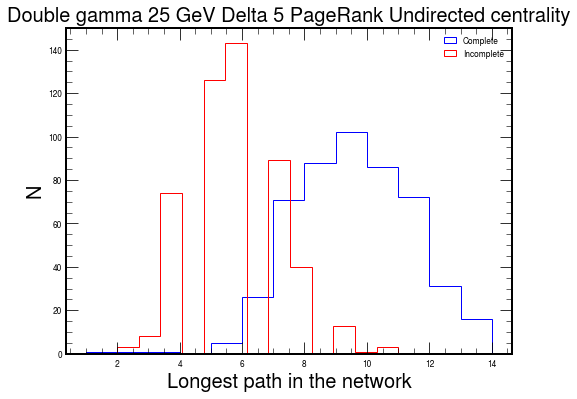

In [60]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPaths[:,1], bins=(max(longestComPaths[:,1])-min(longestComPaths[:,1])), color='b', histtype="step",label='Complete')
plt.hist(longestInComPaths[:,1], bins=(max(longestComPaths[:,1])-min(longestComPaths[:,1])), color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path in the network",fontsize=20)
plt.title(datasetName+" PageRank Undirected centrality",fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRUnDirCent_longestPath.png")
plt.show()

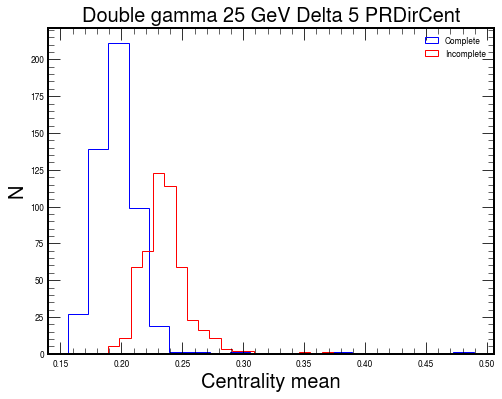

In [61]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,0], bins=20, color='b', histtype="step",label='Complete')
plt.hist(incCenParams[:,0], bins=20, color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality mean",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRDirCent_mean.png")
plt.show()

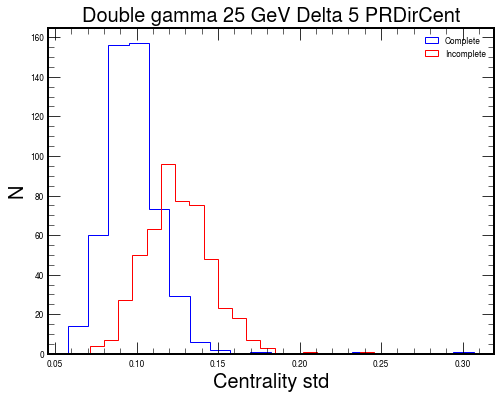

In [62]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,1], bins=20, color='b', histtype="step",label='Complete')
plt.hist(incCenParams[:,1], bins=20, color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality std",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRDirCent_std.png")
plt.show()

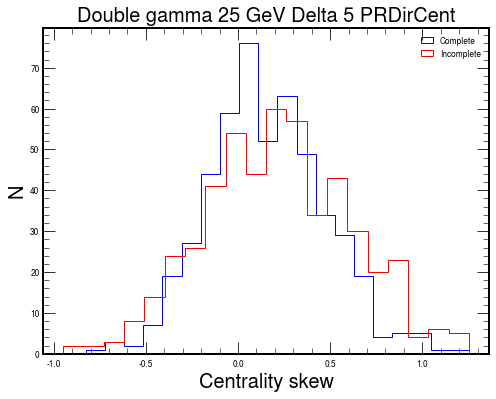

In [63]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,2], bins=20, color='b', histtype="step",label='Complete')
plt.hist(incCenParams[:,2], bins=20, color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality skew",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRDirCent_skew.png")
plt.show()

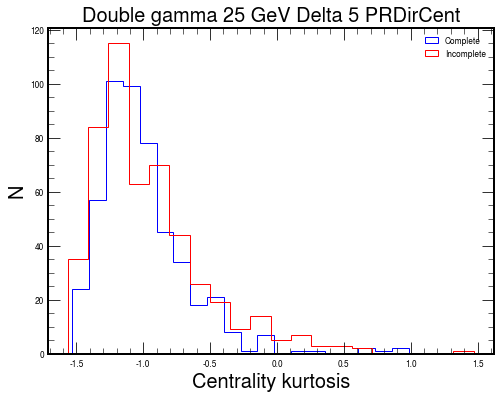

In [64]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(comCenParams[:,3], bins=20, color='b', histtype="step",label='Complete')
plt.hist(incCenParams[:,3], bins=20, color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Centrality kurtosis",fontsize=20)
plt.title(datasetName+centralityName,fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRDirCent_kurtosis.png")
plt.show()

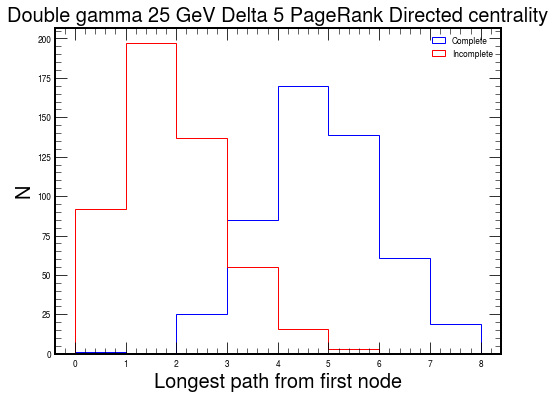

In [65]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPathsFirstNode[:,0], bins=(max(longestComPathsFirstNode[:,0])-min(longestComPathsFirstNode[:,0])), color='b', histtype="step",label='Complete')
plt.hist(longestInComPathsFirstNode[:,0], bins=(max(longestInComPathsFirstNode[:,0])-min(longestInComPathsFirstNode[:,0])), color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path from first node",fontsize=20)
plt.title(datasetName+" PageRank Directed centrality",fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRDirCent_longestPathFirstNode.png")
plt.show()

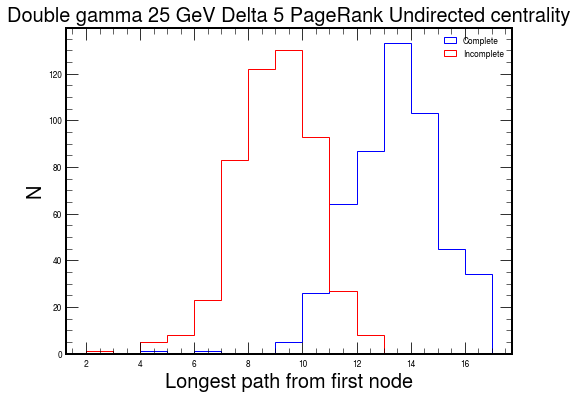

In [66]:
%matplotlib inline

plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(longestComPathsFirstNode[:,1], bins=(max(longestComPathsFirstNode[:,1])-min(longestComPathsFirstNode[:,1])), color='b', histtype="step",label='Complete')
plt.hist(longestInComPathsFirstNode[:,1], bins=(max(longestInComPathsFirstNode[:,1])-min(longestInComPathsFirstNode[:,1])), color='r', histtype="step",label='Incomplete')
plt.legend()
plt.ylabel("N",fontsize=20)
plt.xlabel("Longest path from first node",fontsize=20)
plt.title(datasetName+" PageRank Undirected centrality",fontsize=20)
plt.savefig("figures/"+folder+"/"+"incVsCom_PRUnDirCent_longestPathFirstNode.png")
plt.show()

In [145]:
clusters_eta=clusters['position_eta'].array()
clusters_phi=clusters['position_phi'].array()
clusters_type=clusters['cluster_type'].array()
recHits_indexes=tracksters['recHits_indexes'].array()

In [146]:
print(ak.count(clusters_eta,axis=1))
print(len(clusters_eta))
print(clusters_eta)
print(ak.count(vertices_indexes,axis=2))
print(ak.count(recHits_indexes,axis=2))
print(recHits_indexes)
print(vertices_indexes)
print(clusters_type)

[289, 308, 337, 328, 298, 320, 307, 319, ... 312, 280, 305, 290, 317, 331, 287, 355]
500
[[1.82, 1.6, 1.63, 1.62, 1.62, 1.62, 1.57, ... 1.65, 1.67, 1.64, 1.69, 1.59, 1.71]]
[[18, 25, 5], [26, 23], [23, 39], [25, 34, ... 39, 2], [28, 24], [27, 26], [31, 26]]
[[337, 360, 42], [390, 425], [349, 467], ... [394, 419], [377, 386], [417, 373]]
[[[3, 3, 3, 4, 4, 4, 4, 4, 4, 10, ... 320, 320, 335, 335, 335, 335, 335, 341, 341]]]
[[[3, 4, 10, 20, 29, 39, 54, 69, 85, ... 280, 282, 296, 300, 318, 320, 335, 341]]]
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]


In [ ]:
longestComPaths=[]
longestInComPaths=[]

N = len(vertices_indexes)
#N_tr=1000

for evt in range(N):
    for tr in range(min(len(vertices_indexes[evt]),2)):
        v_layers=vertices_layer[evt][tr]
        v_ind=vertices_indexes[evt][tr]
        v_x=vertices_x[evt][tr]
        v_y=vertices_y[evt][tr]
        v_z=vertices_z[evt][tr]
        v_E=vertices_E[evt][tr] 
        edges_1 = fn.edgeBuilderNew(
            v_ind,
            v_x, 
            v_y, 
            v_z, 
            v_E
        )
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
        #print(evt,tr)


        #c_nxkatz_dir=fn.nXCentralityKatz(v_ind,edges_1,True)
        #c_nxkatz_undir=fn.nXCentralityKatz(v_ind,edges_1,False)
        #c_nxeig_undir=fn.nXCentralityEigen(v_ind,edges_1,False)
        #c_katz=fn.centralityKatz(v_ind,edges_1,False)
        #c_eig_undir=fn.centralityEigen(v_ind,edges_1,False)




        if(tracksterChoice[evt,tr]):
            c_pr_dir=fn.centralityPageRank(v_ind,edges_1,0.85,True)
            c_pr_undir=fn.centralityPageRank(v_ind,edges_1,0.85,False)

            longestComPaths.append([fn.longestPathSource(v_ind,edges_1,c_pr_dir,True),fn.longestPathSource(v_ind,edges_1,c_pr_undir)])
        else:
            v_ind_inc=v_ind[incSlice]
            v_x_inc=v_x[incSlice]
            v_y_inc=v_y[incSlice]
            v_z_inc=v_z[incSlice]
            v_E_inc=v_E[incSlice]
            edges_1 = fn.edgeBuilderNew(
                v_ind_inc,
                v_x_inc, 
                v_y_inc, 
                v_z_inc,
                v_E_inc
            )
            edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
            if(len(v_ind_inc)<3):
                continue
            c_pr_dir=fn.centralityPageRank(v_ind_inc,edges_1,0.85,True)
            c_pr_undir=fn.centralityPageRank(v_ind_inc,edges_1,0.85,False)

            longestInComPaths.append([fn.longestPathSource(v_ind_inc,edges_1,c_pr_dir,True),fn.longestPathSource(v_ind_inc,edges_1,c_pr_undir)])
 



In [ ]:
comCenParams=[]
incCenParams=[]

N = len(vertices_indexes)
#N_tr=1000

for evt in range(N):
    for tr in range(min(len(vertices_indexes[evt]),2)):
        v_layers=vertices_layer[evt][tr]
        v_ind=vertices_indexes[evt][tr]
        v_x=vertices_x[evt][tr]
        v_y=vertices_y[evt][tr]
        v_z=vertices_z[evt][tr]
        v_E=vertices_E[evt][tr] 
        edges_1 = fn.edgeBuilderNew(
            v_ind,
            v_x, 
            v_y, 
            v_z, 
            v_E
        )
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())


        #c_nxkatz_dir=fn.nXCentralityKatz(v_ind,edges_1,True)
        #c_nxkatz_undir=fn.nXCentralityKatz(v_ind,edges_1,False)
        #c_nxeig_undir=fn.nXCentralityEigen(v_ind,edges_1,False)
        #c_katz=fn.centralityKatz(v_ind,edges_1,False)
        #c_eig_undir=fn.centralityEigen(v_ind,edges_1,False)




        if(tracksterChoice[evt,tr]):
            c_pr_dir=fn.centralityPageRank(v_ind,edges_1,0.85,True)
            #c_pr_undir=fn.centralityPageRank(v_ind,edges_1,0.85,False)
            centrality=c_pr_dir
            comCenParams.append([np.mean(centrality),np.std(centrality)
                             ,scipy.stats.skew(centrality),scipy.stats.kurtosis(centrality)])
        else:
            v_ind_inc=v_ind[incSlice]
            v_x_inc=v_x[incSlice]
            v_y_inc=v_y[incSlice]
            v_z_inc=v_z[incSlice]
            v_E_inc=v_E[incSlice]
            edges_1 = fn.edgeBuilderNew(
                v_ind_inc,
                v_x_inc, 
                v_y_inc, 
                v_z_inc,
                v_E_inc
            )
            edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
            if(len(v_ind_inc)<3):
                continue
            c_pr_dir=fn.centralityPageRank(v_ind_inc,edges_1,0.85,True)
            #c_pr_undir=fn.centralityPageRank(v_ind_inc,edges_1,0.85,False)
            centrality=c_pr_dir
            incCenParams.append([np.mean(centrality),np.std(centrality)
                             ,scipy.stats.skew(centrality),scipy.stats.kurtosis(centrality)])



In [ ]:
longestComPathsFirstNode=[]
longestInComPathsFirstNode=[]

N = len(vertices_indexes)
#N_tr=1000

for evt in range(N):
    for tr in range(min(len(vertices_indexes[evt]),2)):
        v_layers=vertices_layer[evt][tr]
        v_ind=vertices_indexes[evt][tr]
        v_x=vertices_x[evt][tr]
        v_y=vertices_y[evt][tr]
        v_z=vertices_z[evt][tr]
        v_E=vertices_E[evt][tr] 
        edges_1 = fn.edgeBuilderNew(
            v_ind,
            v_x, 
            v_y, 
            v_z, 
            v_E
        )
        edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
        #print(evt,tr)


        #c_nxkatz_dir=fn.nXCentralityKatz(v_ind,edges_1,True)
        #c_nxkatz_undir=fn.nXCentralityKatz(v_ind,edges_1,False)
        #c_nxeig_undir=fn.nXCentralityEigen(v_ind,edges_1,False)
        #c_katz=fn.centralityKatz(v_ind,edges_1,False)
        #c_eig_undir=fn.centralityEigen(v_ind,edges_1,False)




        if(tracksterChoice[evt,tr]):

            longestComPaths.append([fn.longestPathInitialNode(v_ind,edges_1,True),fn.longestPathInitialNode(v_ind,edges_1)])
        else:
            
            v_ind_inc=v_ind[incSlice]
            v_x_inc=v_x[incSlice]
            v_y_inc=v_y[incSlice]
            v_z_inc=v_z[incSlice]
            v_E_inc=v_E[incSlice]
            edges_1 = fn.edgeBuilderNew(
                v_ind_inc,
                v_x_inc, 
                v_y_inc, 
                v_z_inc,
                v_E_inc
            )
            edges_1 = ak.flatten(edges_1[ak.num(edges_1) > 0].to_list())
            if(len(v_ind_inc)<2):
                continue

            longestInComPaths.append([fn.longestPathInitialNode(v_ind_inc,edges_1,True),fn.longestPathInitialNode(v_ind_inc,edges_1)])
 

